### Screen Cleaned Twitter Data by Poet Features

In [16]:
from tqdm import tqdm_notebook
import pandas as pd
import os
import pickle
import numpy as np
from nltk.tokenize import TweetTokenizer
from collections import defaultdict, Counter

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set(color_codes=True)

from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
# load clean tweets
df_clean = pd.DataFrame()
for i in tqdm_notebook(range(29)):
    
    with open('tweet_clean{}.pkl'.format(i), 'rb') as filehandle:  
    # read the data as binary data stream
        df_slice = pickle.load(filehandle)
        
    df_clean = pd.concat([df_clean, df_slice], ignore_index=True)

df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293881 entries, 0 to 2293880
Data columns (total 9 columns):
id           object
date         datetime64[ns]
text         object
author       object
favorite     int64
url          object
lang         object
length       int64
cleantext    object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 157.5+ MB


In [3]:
# List of Poets
poets = list(set(df_clean['author'].tolist()))
len(poets)

262

In [4]:
tknzr = TweetTokenizer()
tok_list = []
len_list = []

for i,nrows in tqdm_notebook(df_clean.iterrows()):
    word_list = tknzr.tokenize(nrows['cleantext'])
    tok_list.append(word_list)
    len_list.append(len(word_list))
                    
df_clean['tokens'] = tok_list
df_clean['count'] = len_list

In [5]:
df_clean.sample(10)

,id,date,text,author,favorite,url,lang,length,cleantext,tokens,count
2142609,62935874526134273,2011-04-26 10:47:36,"@ theplayethic By the way, if any of this is u...",leashless,1,https://twitter.com/leashless/status/629358745...,en,71,"By the way, if any of this is useful, please d...","[By, the, way, ,, if, any, of, this, is, usefu...",17
2255195,628635047336280064,2015-08-04 11:34:09,"Sony's plan for music industry: ""International...",wikileaks,59,https://twitter.com/wikileaks/status/628635047...,en,111,"Sony's plan for music industry: ""International...","[Sony's, plan, for, music, industry, :, "", Int...",21
1002433,905827228214214656,2017-09-07 09:16:55,I guarantee it was a Carl Cargill headfake -- ...,BrendanEich,4,https://twitter.com/BrendanEich/status/9058272...,en,78,I guarantee it was a Carl Cargill headfake -- ...,"[I, guarantee, it, was, a, Carl, Cargill, head...",17
107264,1059415208773513216,2018-11-05 04:00:43,Related: I accuse @ jihanwu @ AntPoolofficial ...,CarpeNoctom,2,https://twitter.com/CarpeNoctom/status/1059415...,en,48,Related: I accuse and of using covert ASICboost…,"[Related, :, I, accuse, and, of, using, covert...",10
366458,875070429970530304,2017-06-14 12:20:23,HAHAHAHAHA. i am full of inspirational quotes ...,Melt_Dem,11,https://twitter.com/Melt_Dem/status/8750704299...,en,139,HAHAHAHAHA. i am full of inspirational quotes ...,"[HAHAHAHAHA, ., i, am, full, of, inspirational...",33
1637202,586629479897833472,2015-04-10 13:39:01,California Senate Committee Votes to End Vacci...,zaoyang,0,https://twitter.com/zaoyang/status/58662947989...,en,74,California Senate Committee Votes to End Vacci...,"[California, Senate, Committee, Votes, to, End...",10
1505405,572805008808398849,2015-03-03 09:05:30,How I did on Twitter this week: 192 New Follow...,BKBrianKelly,3,https://twitter.com/BKBrianKelly/status/572805...,en,108,How I did on Twitter this week: 192 New Follow...,"[How, I, did, on, Twitter, this, week, :, 192,...",25
337397,476657531805114369,2014-06-11 02:29:46,'The People's Water Cannon' is now the 'staff ...,maxkeiser,4,https://twitter.com/maxkeiser/status/476657531...,en,104,'The People's Water Cannon' is now the 'staff ...,"[', The, People's, Water, Cannon, ', is, now, ...",21
1762518,1132102524398387200,2019-05-24 18:54:09,Great article by @ ferdousbhai !,notsofast,7,https://twitter.com/notsofast/status/113210252...,en,18,Great article by !,"[Great, article, by, !]",4
88403,806492820114735104,2016-12-07 05:37:26,they prob use that to eat cereal too,CarpeNoctom,0,https://twitter.com/CarpeNoctom/status/8064928...,en,36,they prob use that to eat cereal too,"[they, prob, use, that, to, eat, cereal, too]",8


In [8]:
# build a poet table for screening
p_counters = []
starts = []
stops = []
num_tweets = []
wrd_counts = []
vocabs = []

for poet in tqdm_notebook(poets):
    
    df_slice = df_clean[df_clean['author'] == poet]
    
    dates = df_slice['date'].tolist()
    starts.append(min(dates))
    stops.append(max(dates))
    num_tweets.append(len(df_slice))
    
    wtc = Counter()
    for _,nrows in df_slice.iterrows():
        for token in nrows['tokens']:
            wtc[token] += 1  
            
    p_counters.append(wtc) 
    wrd_counts.append(sum(wtc.values()))
    vocabs.append(len(wtc))
    
df_poets = pd.DataFrame()
df_poets['author'] = poets
df_poets['start'] = starts
df_poets['stop'] = stops
df_poets['num_tweets'] = num_tweets
df_poets['total_words'] = wrd_counts
df_poets['vocab_size'] = vocabs

In [9]:
df_poets.sample(10)

,author,start,stop,num_tweets,total_words,vocab_size
182,oleganza,2009-07-01 14:51:44,2019-05-26 23:52:14,11996,217289,18657
61,starkness,2009-01-05 11:32:41,2019-05-25 13:41:36,8680,130477,11534
255,BITMAINtech,2013-11-16 02:46:50,2019-05-18 03:07:21,783,15585,2581
69,KyleSamani,2009-06-10 23:45:36,2019-06-04 14:41:06,8391,148051,14831
172,ryaneshea,2010-06-25 11:30:40,2019-06-03 11:25:22,4845,91163,10808
70,santisiri,2009-01-03 22:54:18,2019-05-27 11:04:03,19079,295110,21451
77,MatthewRoszak,2011-07-26 20:25:01,2019-05-14 21:49:08,122,1745,798
59,xapo,2013-11-14 08:50:29,2019-06-05 02:06:16,23189,329172,2010
13,BTCVIX,2011-08-02 10:05:15,2019-05-30 09:29:17,12665,238460,16089
25,Poloniex,2014-01-18 19:44:16,2019-06-05 08:29:02,2660,70081,3934


In [47]:
# save for study
df_poets.to_csv('poet_table_061219.csv', index=False)

In [17]:
def kurtosis_skewness(data):
    print( '      kurtosis=',"%.1f" % kurtosis(data), '   skewness=',"%.1f" % skew(data), '     sum=',np.sum(data))
    print()

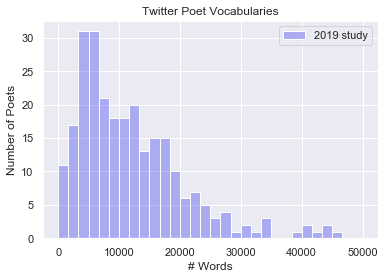

mined dataset
      kurtosis= 13.8    skewness= 2.8      sum= 3344991



In [27]:
# initialize list
data1 = df_poets['vocab_size'].tolist()

# set up a beautiful plot        
plt.hist(data1,30,(0,50000), color = (.1,.1,.95,.3), label = '2019 study')
plt.legend(loc='upper right')
plt.title('Twitter Poet Vocabularies')
plt.xlabel('# Words')
plt.ylabel('Number of Poets')
plt.show()
        
# after histogram, print out the distribution descriptors
print('mined dataset')
kurtosis_skewness(data1)

In [20]:
# Show Statistics of tweets
df_clean.describe()

,favorite,length,count
count,2.293881e+06,2.293881e+06,2.293881e+06
mean,3.591162e+02,8.999038e+01,1.814827e+01
std,5.691165e+03,5.817453e+01,1.181011e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.800000e+01,1.000000e+01
50%,2.000000e+00,8.100000e+01,1.600000e+01
75%,9.000000e+00,1.170000e+02,2.400000e+01
max,1.197117e+06,1.554000e+03,4.140000e+02


In [21]:
# Show Statistics of poets
df_poets.describe()

,num_tweets,total_words,vocab_size
count,262.000000,2.620000e+02,262.000000
mean,8755.270992,1.588930e+05,12767.141221
std,14673.939902,2.429460e+05,11105.632250
min,18.000000,3.920000e+02,235.000000
25%,1726.250000,3.524425e+04,5384.000000
50%,4623.000000,9.044000e+04,10092.500000
75%,10677.250000,1.815368e+05,16715.250000
max,174184.000000,2.447514e+06,96069.000000


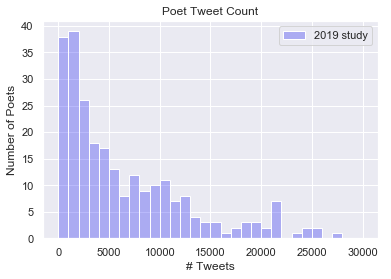

mined dataset
      kurtosis= 13.8    skewness= 2.8      sum= 3344991



In [28]:
# initialize list
data2 = df_poets['num_tweets'].tolist()

# set up a beautiful plot        
plt.hist(data2,30,(0,30000), color = (.1,.1,.95,.3), label = '2019 study')
plt.legend(loc='upper right')
plt.title('Poet Tweet Count')
plt.xlabel('# Tweets')
plt.ylabel('Number of Poets')
plt.show()
        
# after histogram, print out the distribution descriptors
print('mined dataset')
kurtosis_skewness(data1)

In [23]:
# who tweets the most?
df_poets[df_poets['num_tweets']==174184]['author']

181    TheStalwart
Name: author, dtype: object

In [24]:
# who tweets the least in English?
df_poets[df_poets['num_tweets']==18]['author']

9    jeremyrwelch
Name: author, dtype: object

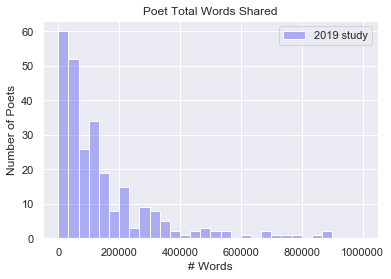

mined dataset
      kurtosis= 13.8    skewness= 2.8      sum= 3344991



In [30]:
# initialize list
data3 = df_poets['total_words'].tolist()

# set up a beautiful plot        
plt.hist(data3,30,(0,1e6), color = (.1,.1,.95,.3), label = '2019 study')
plt.legend(loc='upper right')
plt.title('Poet Total Words Shared')
plt.xlabel('# Words')
plt.ylabel('Number of Poets')
plt.show()
        
# after histogram, print out the distribution descriptors
print('mined dataset')
kurtosis_skewness(data1)

In [35]:
# Screen Poets
# vocab < 30,000
# tweets > 3,000
# words < 1M

df_screen = df_poets[(df_poets['vocab_size']<=30000) & (df_poets['num_tweets']>=3000) & (df_poets['total_words']<=1e6)]
df_screen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 261
Data columns (total 6 columns):
author         143 non-null object
start          143 non-null datetime64[ns]
stop           143 non-null datetime64[ns]
num_tweets     143 non-null int64
total_words    143 non-null int64
vocab_size     143 non-null int64
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 7.8+ KB


In [40]:
selected = sorted(df_screen['author'].tolist())
print(selected)

['APompliano', 'AaronvanW', 'AdamDraper', 'AlenaSatoshi', 'AlyseKilleen', 'AmberBaldet', 'AriDavidPaul', 'AriannaSimpson', 'BKBrianKelly', 'BTCFoundation', 'BTCVIX', 'BitCoinSusan', 'BitPay', 'Bitcoin', 'BitcoinMagazine', 'BitfuryGeorge', 'BittrexExchange', 'CharlieShrem', 'ChristopherA', 'CoinMarketCap', 'CollinCrypto', 'CryptOrca', 'CryptoBull', 'CryptoCobain', 'CryptoCred', 'CryptoHustle', 'DelRayMan', 'Disruptepreneur', 'ErikVoorhees', 'Excellion', 'Gemini', 'IOHK_Charles', 'JeremyRubin', 'Joi', 'KyleSamani', 'LukeDashjr', 'Melt_Dem', 'MustStopMurad', 'NeerajKA', 'NickSzabo4', 'PeterLBrandt', 'PeterMcCormack', 'SatoshiLite', 'ShapeShift_io', 'SunnyRayShow', 'TheBlock__', 'TheBlueMatt', 'ToneVays ', 'Trezor', 'VentureCoinist', 'VinnyLingham', 'VitalikButerin', 'VladZamfir', 'WayneVaughan', 'WhalePanda', '_jillruth', 'aantonop', 'adam3us ', 'adamludwin', 'alansilbert', 'albertwenger', 'alexbosworth', 'alistairmilne', 'arjunblj', 'arrington', 'austinhill', 'barrysilbert ', 'billbarhyd

In [37]:
# Show Statistics of poets
df_screen.describe()

,num_tweets,total_words,vocab_size
count,143.000000,143.000000,143.000000
mean,9604.524476,178538.286713,14954.727273
std,5535.568397,117498.148189,5592.487233
min,3032.000000,35983.000000,2010.000000
25%,5172.000000,101147.000000,10925.000000
50%,8448.000000,136780.000000,14531.000000
75%,12217.500000,224813.500000,18294.000000
max,25337.000000,678595.000000,29240.000000


In [42]:
# save for maintenance mining later
with open('screened_seeds_06119.pkl', 'wb') as filehandle:  
    # store the data as binary data stream
    pickle.dump(selected, filehandle)

In [43]:
# build screened dataframe

df_cleanscreen = pd.DataFrame()

for poet in tqdm_notebook(selected):
    
    df_slice = df_clean[df_clean['author'] == poet]
    df_cleanscreen = pd.concat([df_cleanscreen, df_slice], ignore_index=True)

df_cleanscreen.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373447 entries, 0 to 1373446
Data columns (total 11 columns):
id           1373447 non-null object
date         1373447 non-null datetime64[ns]
text         1373447 non-null object
author       1373447 non-null object
favorite     1373447 non-null int64
url          1373447 non-null object
lang         1373447 non-null object
length       1373447 non-null int64
cleantext    1373447 non-null object
tokens       1373447 non-null object
count        1373447 non-null int64
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 115.3+ MB


<function matplotlib.pyplot.show(*args, **kw)>

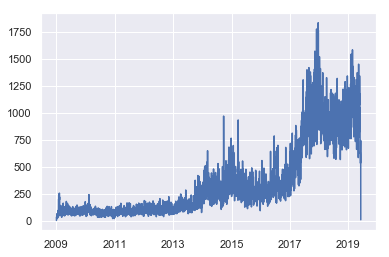

In [44]:
# plot cleaned and screened tweets per day over 10 years
df_copytime = df_cleanscreen.copy()
df_copytime.set_index('date', inplace=True)
df = df_copytime.groupby(df_copytime.index.date).count()
plt.plot(df.index, df['id'])
plt.show

In [45]:
# split giant dataframe into 17 pieces having 80791 rows each
df_cs = df_cleanscreen.copy()
df_split = np.array_split(df_cs, 17, axis=0)

# clean the dataframes, filter out the non-English entries
for i in tqdm_notebook(range(17)):
    
    # output to pickle
    with open('tweet_screen{}.pkl'.format(i), 'wb') as filehandle:  
        # store the data
        pickle.dump(df_split[i], filehandle)

In [46]:
# just wondering
df_poets[df_poets['author']=='realDonaldTrump']

,author,start,stop,num_tweets,total_words,vocab_size
250,realDonaldTrump,2009-05-04 11:54:25,2019-06-05 05:18:50,36711,799685,34583


note large vocabulary could indicate large number of misspellings and typos.